# raster data

In [1]:
import os

import geopandas as gpd
import polars as pl
import psycopg2
from dotenv import load_dotenv

load_dotenv()
URI = os.getenv("POSTGRES")

## 1. Fetch raster data 
### 1.1. fetch from PostGIS

The example here is the DTM raster data from Renai Nantou, Taiwan. The data is stored in a PostGIS database. We will fetch the data and display it using the `rasterio` library.

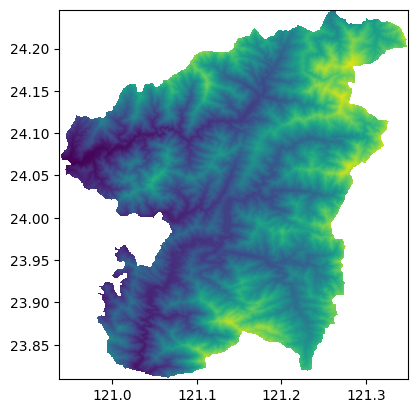

In [2]:
from rasterio.io import MemoryFile
from rasterio.plot import show


with psycopg2.connect(URI) as conn:
    with conn.cursor() as cur:
        cur.execute('''
        SET postgis.gdal_enabled_drivers TO 'GTiff';

        WITH boundary AS (
        SELECT geometry as geom
        FROM geometry.boundary_town
        WHERE city_name = '南投縣' and town_name = '仁愛鄉'
        )
        SELECT ST_AsGDALRaster(
            ST_Union(ST_Clip(rast, geom)), 'GTiff'
            ) AS clipped_raster
        FROM geometry.nature_dtm, boundary
        WHERE ST_Intersects(rast, geom)
        ''')

        for row in cur:
            rast = row[0].tobytes()
            with MemoryFile(rast).open() as dataset:
                data_array = dataset.read()
                transform = dataset.transform
                nodata_value = dataset.nodata
                show(dataset)

### 1.2. Use `rasterio` to read raster data

NOTE: Before processing raster data to h3, you have to check the crs of the raster data. If the crs is not EPSG:4326, you have to reproject the raster data to EPSG:4326.


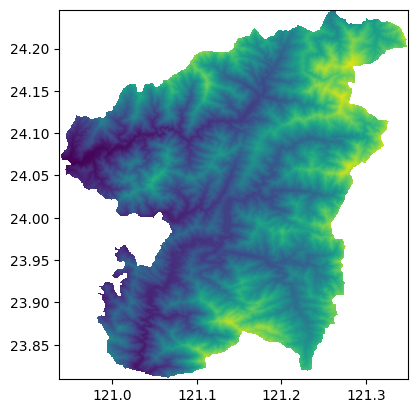

In [3]:
import rasterio as rio

with rio.open('data/test_raster.tif') as src:
    data = src.read()
    transform = src.transform
    nodata = src.nodata
    show(src)

## 2. Convert raster to h3

use `process_from_raster()` function to convert raster to h3, don't need to set_aggregation_strategy, because the `process_from_raster()` can only accept one band at the time (2D array).

In [4]:
from h3_toolkit import H3Toolkit

toolkit = H3Toolkit()

result = (
    toolkit
    .process_from_raster(
        data = data_array[0],
        transform = transform,
        resolution = 12,
        nodata_value= int(nodata_value)
    )
)

output_12 = result.get_result()
output_12.head()

hex_id,value
str,i16
"""8c4ba068a01b5ff""",3114
"""8c4ba068a0517ff""",3114
"""8c4ba068a0a2dff""",3114
"""8c4ba068a0b53ff""",3114
"""8c4ba068a1831ff""",3114


## 3. Scale current h3 resolution to the target resolution

In [5]:
from h3_toolkit.aggregation import Mean

toolkit = H3Toolkit()

result = (
    toolkit
    .set_aggregation_strategy(
        {
            'value': Mean()
        }
    )
    .process_from_h3(
        data = output_12,
        source_resolution = 12,
        target_resolution= 9,
        h3_col='hex_id'
    )
)

output_9 = result.get_result()
output_9.head()

hex_id,value
str,f64
"""894ba2af297ffff""",1290.469388
"""894ba2aeab7ffff""",1050.22449
"""894ba2a6663ffff""",918.422741
"""894ba068647ffff""",1881.798834
"""894ba2a5647ffff""",701.043732


## 4. Visualization

In [6]:
import mapclassify as mc
import pandas as pd
import pydeck as pdk
from matplotlib import colormaps

INITIAL_VIEW_STATE = {
    'latitude':24.032518695904923,
    'longitude':121.15366859978752,
    'zoom':9.5,
    'max_zoom':13,
    'pitch':0,
    'bearing':0
}

In [7]:
def _set_color(
    data:pl.DataFrame | gpd.GeoDataFrame,
    target_col:str,
) -> pd.DataFrame | gpd.GeoDataFrame:
    """set color column for data based on target_col
    """

    # change this classifier to fit your data
    classifier = mc.NaturalBreaks(data[target_col], k=5)
    cmap = colormaps.get_cmap('Greens')

    if isinstance(data, pl.DataFrame):
        data = data.to_pandas()
    data['interval'] = classifier.find_bin(data[target_col])
    data['color'] = data['interval'].apply(lambda x: cmap(x / data['interval'].max()))
    data['color'] = data['color'].apply(lambda c: [int(255 * i) for i in c[:3]] + [255])
    data = data.drop(columns='interval')

    return data


def show_h3(
    data:pl.DataFrame,
    target_col:str,
    h3_col='hex_id'
):
    """show h3 hexagon layer
    """

    data = data.clone()
    data = _set_color(data, target_col)
    data = data.to_dict(orient='records')

    layer_h3 = pdk.Layer(
        'H3HexagonLayer',
        data,
        get_fill_color='color',
        # get_line_color=[255, 255, 255],
        # get_elevation='p_cnt',
        get_hexagon=h3_col,
        pickable=True,
        opacity=0.4,
        stroked=False,
        filled=True,
        extruded=False,
    )

    r = pdk.Deck(
        layers=[layer_h3],
        initial_view_state=pdk.ViewState(**INITIAL_VIEW_STATE),
        tooltip={"text": f"{target_col}: {{{target_col}}}"}
    )
    return r

In [ ]:
show_h3(output_9, 'value')

Due to performance limitations when rendering large H3 datasets on the web, here’s a screenshot example of the visualization. For an interactive map, you can clone the notebook and run it locally in your environment


![res9](./img/02-1.png)